# Chest CT Scan - Computer Vision Classification
 There are many techniques we can use to do this however, since we have a small set of LIDC IDRI dataset, we will be using transfer learning and a deep neural network to classify the images. In addition, we will use augmentation to generate more images for the model to train on.

----

Identifying cancer is an important research step toward healthier lives. By using diagnosed ground truth labels of patients, we are creating a better future for others by being able to catch cancer faster, and therefore save lives. Sometimes, there are instances when a human eye does not notice something in an image, but a computer can. Further, these instances can often be life-threatening; if a computer can learn the nuaneces that determine cancer, perhaps something that even doctors don't necessarily notice right away, we can support the medical professionals in their diagnosis.


In [ ]:
!pip install tensorflow_addons

In [ ]:
#import libraries
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import os
from skimage import io
from skimage.color import rgb2gray
import plotly.express as px
import random
from sklearn.utils import shuffle
import shutil
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import optimizers
from keras.applications import resnet


import tensorflow_addons as tfa

#check tensorflow verison
tf.__version__

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


'2.12.0'

In [ ]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 10.2 MB/s eta 0:00:00


In [ ]:
# set visualization defaults
plt.rcParams['figure.figsize'] = (15, 5)
plt.rcParams['xtick.color'] = 'dimgrey'
plt.rcParams['ytick.color'] = 'dimgrey'
plt.rcParams['axes.labelcolor'] = 'dimgrey'
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlepad'] = 30
plt.rcParams['axes.titlesize'] = 30
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

In [ ]:
#get global path
from google.colab import drive
drive.mount("/content/gdrive")

global_dir = "gdrive/My Drive/Colab Notebooks/Lung_cancer_codes/deep learning methods/Data/"
os.listdir(global_dir)

Mounted at /content/gdrive


['train', 'valid', 'test', 'transfer_model.hdf5']

In [ ]:
# Set directories
test_dir = "gdrive/My Drive/Colab Notebooks/Lung_cancer_codes/deep learning methods/Data/test"
train_dir = "gdrive/My Drive/Colab Notebooks/Lung_cancer_codes/deep learning methods/Data/train"
valid_dir = "gdrive/My Drive/Colab Notebooks/Lung_cancer_codes/deep learning methods/Data/valid"

In [ ]:
# train sets
for files in os.listdir(train_dir):
    print(os.path.join(train_dir,files))

print('\n')
# valid sets
for files in os.listdir(valid_dir):
    print(os.path.join(valid_dir,files))

print('\n')
# test sets
for files in os.listdir(test_dir):
    print(os.path.join(test_dir,files))

gdrive/My Drive/Colab Notebooks/Lung_cancer_codes/deep learning methods/Data/train/normal
gdrive/My Drive/Colab Notebooks/Lung_cancer_codes/deep learning methods/Data/train/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa
gdrive/My Drive/Colab Notebooks/Lung_cancer_codes/deep learning methods/Data/train/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa
gdrive/My Drive/Colab Notebooks/Lung_cancer_codes/deep learning methods/Data/train/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib


gdrive/My Drive/Colab Notebooks/Lung_cancer_codes/deep learning methods/Data/valid/normal
gdrive/My Drive/Colab Notebooks/Lung_cancer_codes/deep learning methods/Data/valid/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib
gdrive/My Drive/Colab Notebooks/Lung_cancer_codes/deep learning methods/Data/valid/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa
gdrive/My Drive/Colab Notebooks/Lung_cancer_codes/deep learning methods/Data/valid/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa


gdrive/My Drive/Colab Notebooks/Lung_cance

-----

# Model building

In the given datasets, we have three directories/folders: training, validation, testing. We will use cross-validation to produce a stronger model. Further, we will use generators to iterate over the data as well as image augmentation techniques.

In [ ]:
#set globals
BATCH_SIZE = 8
EPOCHS = 20
SEED = 49
H = 300 #Height
W = 400 #Width
IMAGE_SHAPE = (460,460,3)
N_CLASSES = 4
STEPS = 50

In [ ]:
# Setup GPU accelerator - configure Strategy
tpu = None
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu) #Assume TPU
except ValueError:
    strategy = tf.distribute.get_strategy() #if not TPU, set default for GPU/CPU

In [ ]:
train_datagen = ImageDataGenerator(dtype='float32')
train_generator = train_datagen.flow_from_directory(train_dir,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (460,460),
                                                   class_mode = 'categorical')

valid_datagen = ImageDataGenerator(dtype='float32')
valid_generator = valid_datagen.flow_from_directory(valid_dir,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (460,460),
                                                   class_mode = 'categorical')


Found 613 images belonging to 4 classes.
Found 72 images belonging to 4 classes.


In [ ]:
with strategy.scope(): #use TPU/GPU strategy

    res_model = ResNet50(include_top=False,
                         pooling='avg',
                         weights='imagenet',
                         input_shape = (IMAGE_SHAPE))

    for layer in res_model.layers:
        if 'conv5' not in layer.name:
            layer.trainable = False

    resnet_model = Sequential()
    resnet_model.add(res_model)
    resnet_model.add(Dropout(0.4))
    resnet_model.add(Flatten())
    resnet_model.add(BatchNormalization())
    resnet_model.add(Dropout(0.4))
    resnet_model.add(Dense(N_CLASSES, activation='softmax'))
    resnet_model.summary()

    adam_optimizer = tf.keras.optimizers.legacy.Adam(learning_rate= 0.00001,
                                         decay= 1e-5)

    resnet_model.compile(optimizer=adam_optimizer,
                         loss='categorical_crossentropy',
                         metrics=['accuracy']) #need to update to use f1 score too

94765736/94765736 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 batch_normalization (BatchN  (None, 2048)             8192      
 ormalization)                                                   
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 4)                 81

In [ ]:
checkpoint = ModelCheckpoint(filepath='gdrive/My Drive/Colab Notebooks/Lung_cancer_codes/deep learning methods/Data/transfer_model.hdf5',
                               monitor='val_loss',
                               verbose = 1,
                               save_best_only=True)

early_stopping = EarlyStopping(verbose=1,
                               patience=2)

history_model = resnet_model.fit(train_generator,
                               epochs = EPOCHS,
                               verbose = 1,
                               validation_data = valid_generator,
                               callbacks = [checkpoint, early_stopping])

Epoch 1/20
77/77 [==============================] - ETA: 0s - loss: 1.9887 - accuracy: 0.3344
Epoch 1: val_loss improved from inf to 1.35276, saving model to gdrive/My Drive/Colab Notebooks/Lung_cancer_codes/deep learning methods/Data/transfer_model.hdf5
77/77 [==============================] - 769s 10s/step - loss: 1.9887 - accuracy: 0.3344 - val_loss: 1.3528 - val_accuracy: 0.3889
Epoch 2/20
77/77 [==============================] - ETA: 0s - loss: 1.3154 - accuracy: 0.5351
Epoch 2: val_loss improved from 1.35276 to 1.04838, saving model to gdrive/My Drive/Colab Notebooks/Lung_cancer_codes/deep learning methods/Data/transfer_model.hdf5
77/77 [==============================] - 746s 10s/step - loss: 1.3154 - accuracy: 0.5351 - val_loss: 1.0484 - val_accuracy: 0.5556
Epoch 3/20
77/77 [==============================] - ETA: 0s - loss: 1.1334 - accuracy: 0.5840
Epoch 3: val_loss improved from 1.04838 to 0.86609, saving model to gdrive/My Drive/Colab Notebooks/Lung_cancer_codes/deep learnin

In [ ]:
#check keys before plotting
history_model.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

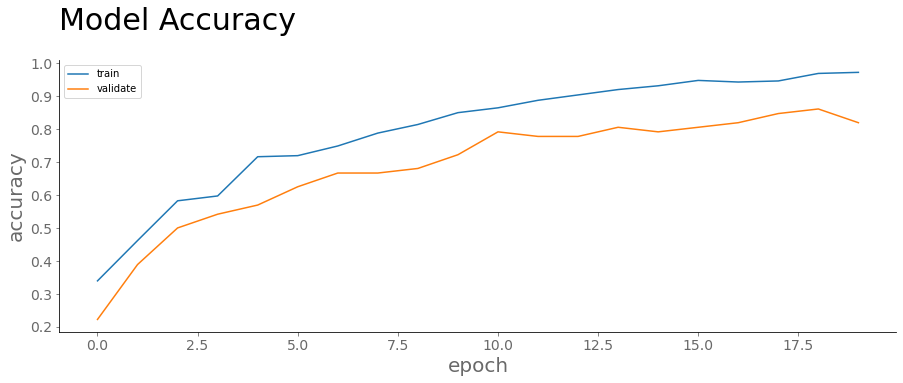

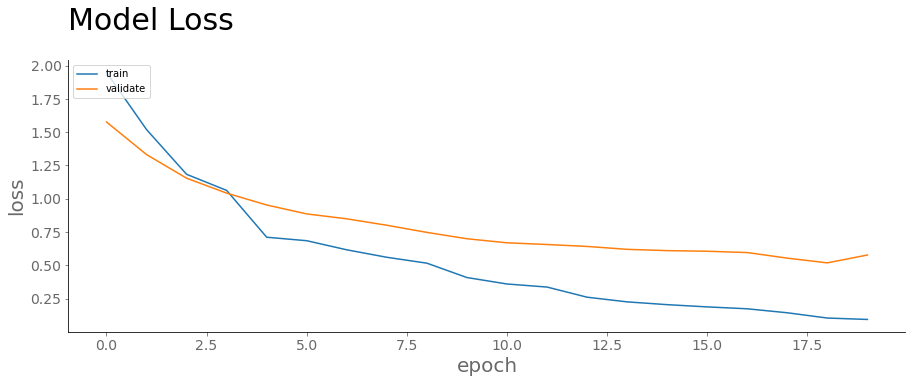

In [ ]:
# graph accuracy
plt.plot(history_model.history['accuracy'])
plt.plot(history_model.history['val_accuracy'])
plt.title('Model Accuracy', loc='left')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();

#graph loss
plt.plot(history_model.history['loss'])
plt.plot(history_model.history['val_loss'])
plt.title('Model Loss', loc='left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();